In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import seaborn as sns
from random import randint
from augment_functions import random_mask

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x = self.data[idx]
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        y = idx
        return x, masked_x, y

In [4]:
model = torch.load('det_autoencoder_X_orig.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.encoder

BATCH_SIZE = 100
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
# Grab a random batch
batch = list(testloader)[randint(0, len(testloader) - 1)]

batch = next(iter(testloader))

x = batch[0].to(DEVICE)
masked_x = batch[1].to(DEVICE)
y = batch[2].to(DEVICE)

print(x.shape)

torch.Size([100, 5, 64, 32])


In [6]:
with torch.no_grad():
    embeddings_x, _= model(x)
    embeddings_masked_x, _ = model(masked_x)

[1.9929761 4.09769   4.6068974 3.8363066 5.384528  3.1265347 3.0733392
 3.634042  4.0703387 3.8277912 2.2682247 2.661091  3.4347875 5.129852
 5.1933904 3.5014763 4.2584586 3.7688737 3.674142  3.6852732 4.176168
 4.7243752 3.4883833 3.9545896 2.815588  4.000781  3.2901702 3.8314362
 3.1735604 4.1990137 4.23458   3.4327269 2.8219936 4.5881534 3.4297743
 3.6994548 4.440405  3.6004717 4.8726983 3.9361424 5.1205864 3.7791107
 3.4892511 3.6793919 2.9716957 5.6592455 3.8777447 3.878793  3.0309258
 4.224461  3.5526767 3.6304793 3.2518487 6.6508355 4.198836  3.8219824
 4.52846   4.198353  4.6827416 3.9225233 3.8088143 4.5441804 3.9067914
 5.130695  4.85844   3.9181118 4.2210035 3.9025528 5.707448  4.0054197
 3.9302793 5.532553  4.015917  4.9964013 4.099929  3.0771616 3.2719345
 4.5164948 4.998767  3.9702172 3.5420344 4.461343  3.831706  3.8527648
 5.4564576 3.7550027 4.833649  3.8608572 4.008442  5.1351957 5.120933
 7.562377  3.992183  3.650628  4.1103573 3.9481244 4.0723386 4.498344
 3.758629 

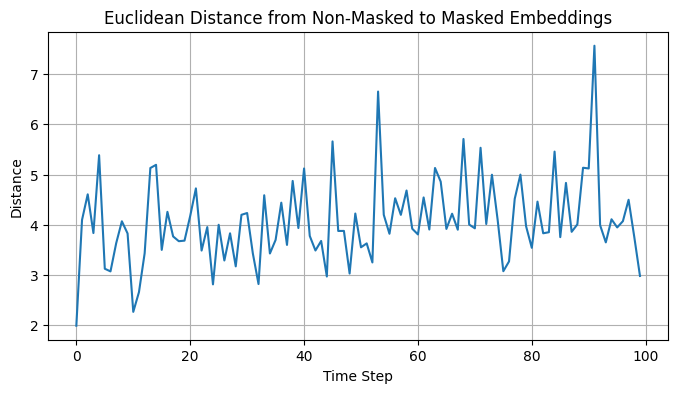

In [7]:
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
print(dist)
plt.figure(figsize=(8, 4))
plt.plot(dist)
plt.title(f'Euclidean Distance from Non-Masked to Masked Embeddings')
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [8]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x])
pca = TSNE(n_components = 2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[:len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x):]


df = pd.DataFrame({
    'x': x_proj[:, 0],
    'y': x_proj[:, 1],
    'labels': y
})

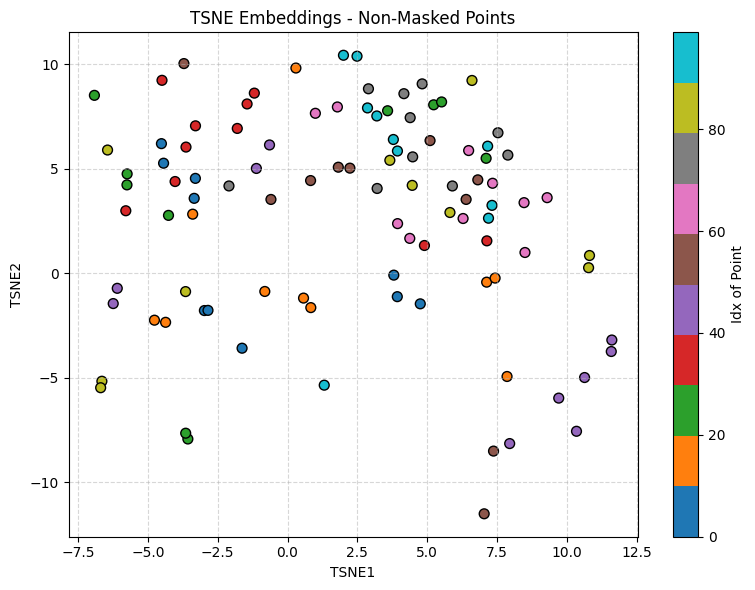

In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE Embeddings - Non-Masked Points')
plt.colorbar(scatter, label='Idx of Point')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
df = pd.DataFrame({
    'x': x_prime_proj[:, 0],
    'y': x_prime_proj[:, 1],
    'labels': y
})

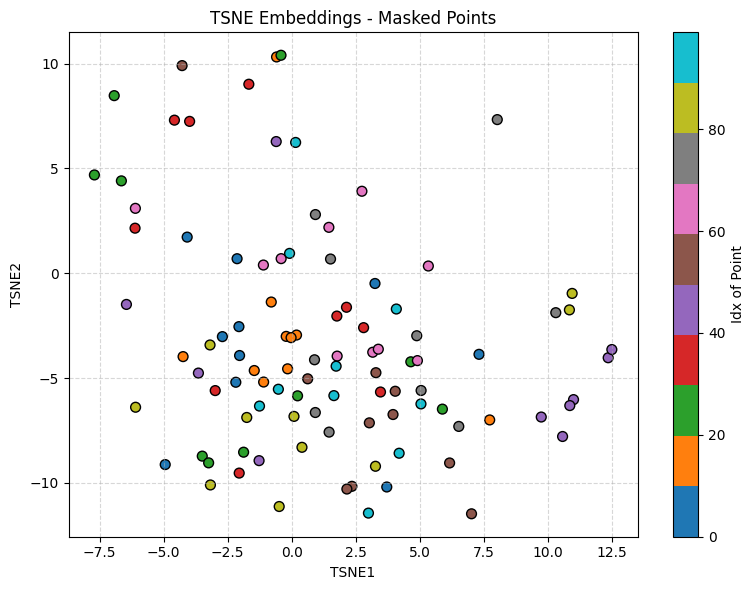

In [11]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE Embeddings - Masked Points')
plt.colorbar(scatter, label='Idx of Point')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
